In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# define constants
IMG_SIZE = 100

In [3]:
def conv2d_out_sz(in_size, kernel_size, pool_size, padding=0, stride=1):
    return ((in_size - kernel_size + 2*padding)/stride + 1)/pool_size

In [4]:
ims = IMG_SIZE # image size
ks = 5 # kernel size
ps = 2 # pool size
out_chan = 64

os = conv2d_out_sz(ims,ks,ps) # outputs to the next layer of conv2d
os = conv2d_out_sz(os,ks,ps) # output size 2
os = conv2d_out_sz(os,ks,ps) # output size 3

fcin = int((int(os)**2)*out_chan)
print(fcin)

5184


In [5]:
class WildfireModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.kernel_size = 5
        
        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16,  kernel_size=self.kernel_size)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=self.kernel_size)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.kernel_size)

        self.fc1 = nn.Linear(fcin, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 8)
        self.fc5 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        x = x.view(-1, fcin)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
                    
        x = F.sigmoid(x)
        return x

In [6]:
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
data = np.load("data.npy", allow_pickle=True)

In [8]:
x = torch.tensor([d[0] for d in data])
x = (x/255.0).view(-1,3,100,100)

y = torch.tensor([float(d[1]) for d in data])

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.1)
(train_x.shape, train_y.shape), (test_x.shape, test_y.shape)

((torch.Size([514, 3, 100, 100]), torch.Size([514])),
 (torch.Size([58, 3, 100, 100]), torch.Size([58])))

tensor(1.)


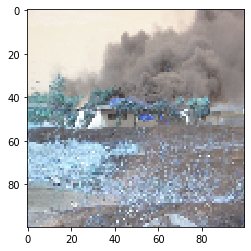

In [9]:
plt.imshow(train_x[9].view(100,100,3))
print(train_y[9])

In [16]:
wfm = WildfireModel()
optimizer = optim.Adam(wfm.parameters(), lr=1e-5)
loss_function = nn.BCELoss()

BATCH_SIZE = 100
EPOCHS = 1000

for epoch in range(EPOCHS):
    for i in range(0, len(train_x), BATCH_SIZE):
        batch_x = train_x[i : i+BATCH_SIZE]
        batch_y = train_y[i : i+BATCH_SIZE]
#         batch_x = train_x[0 : 1]
#         batch_y = train_y[0 : 1]
        batch_y = torch.unsqueeze(batch_y, 1)
        
        wfm.zero_grad()

        outputs = wfm(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}. Loss: {loss}")

Epoch: 0. Loss: 0.6931472420692444
Epoch: 1. Loss: 0.6931472420692444
Epoch: 2. Loss: 0.6931472420692444
Epoch: 3. Loss: 0.6931472420692444
Epoch: 4. Loss: 0.6931472420692444
Epoch: 5. Loss: 0.6931472420692444
Epoch: 6. Loss: 0.6931472420692444
Epoch: 7. Loss: 0.6931472420692444
Epoch: 8. Loss: 0.6931472420692444
Epoch: 9. Loss: 0.6931472420692444


KeyboardInterrupt: 

In [14]:
correct = []
incorrect = []

with torch.no_grad():
    for i in tqdm(range(len(test_x))):
        real_class = test_y[i]
        output = wfm(test_x[i:i+1])[0] # returns a list, grab the 0th 
        predicted_class = np.round(output.detach())
        if predicted_class == real_class:
            correct += [i]
        else:
            incorrect += [i, real_class]

print("Accuracy: ", round(len(correct)/(len(correct) + len(incorrect)), 3))

100%|██████████| 58/58 [00:00<00:00, 138.67it/s]

Accuracy:  0.785
